In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv('/content/drive/MyDrive/utkface_sortAge.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.drop('ethnicity', axis = 1, inplace = True)
df

,age,gender,image
0,1,1,129 161 188 139 165 200 145 166 201 150 170 20...
1,1,0,65 122 208 48 93 159 10 41 86 8 33 68 16 35 72...
2,1,1,124 141 184 127 144 187 129 146 189 131 148 19...
3,1,0,0 0 3 0 0 1 0 1 0 0 1 0 4 6 10 71 106 160 72 1...
4,1,0,68 80 99 111 130 154 123 151 184 120 155 193 9...
...,...,...,...
23703,99,1,74 41 87 64 35 79 50 22 65 50 24 67 48 21 59 2...
23704,99,1,36 41 46 102 111 114 110 117 119 147 147 148 2...
23705,99,1,20 25 24 24 29 28 28 33 32 31 36 35 36 41 40 4...
23706,99,1,91 111 128 102 125 141 123 148 164 142 168 184...


In [4]:
df.age.unique(), df.gender.unique()

(array([  1,  10, 100, 101, 103, 105,  11, 110, 111, 115, 116,  12,  13,
         14,  15,  16,  17,  18,  19,   2,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,   3,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,   4,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
          5,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,   6,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,   7,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,   8,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,   9,  90,  91,  92,  93,  95,  96,  99]),
 array([1, 0]))

____ end ____

In [5]:
df.describe()

,age,gender
count,23708.000000,23708.000000
mean,33.303484,0.477349
std,19.886112,0.499497
min,1.000000,0.000000
25%,23.000000,0.000000
50%,29.000000,0.000000
75%,45.000000,1.000000
max,116.000000,1.000000


<ipython-input-6-32bba7c528dc>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age']);


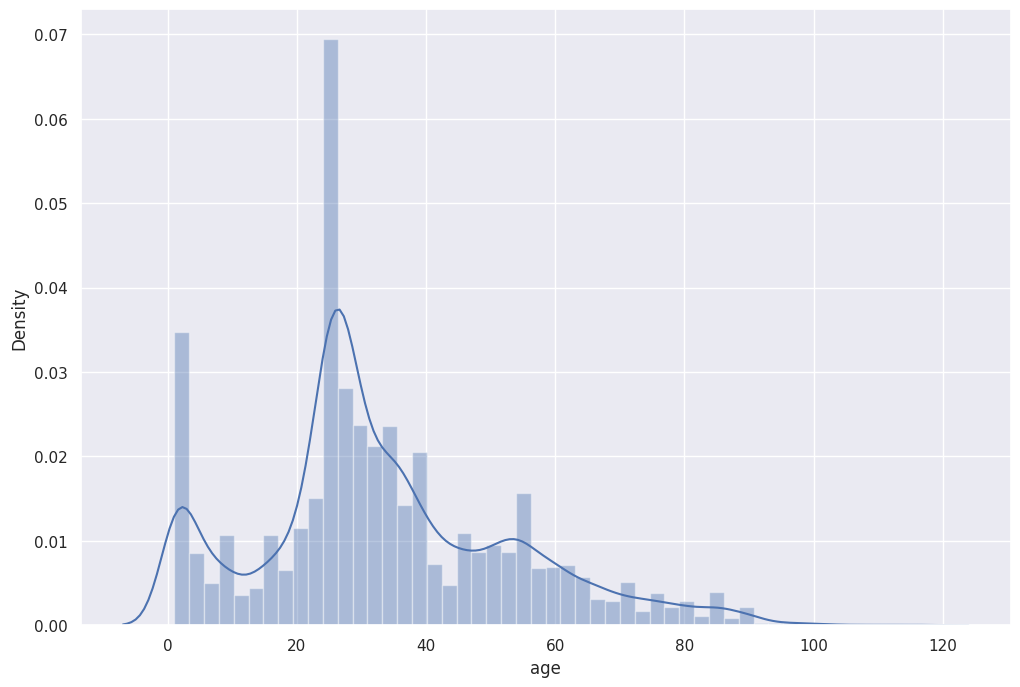

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(df['age']);

In [7]:
df.age.value_counts()

age
26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
111       1
103       1
Name: count, Length: 104, dtype: int64

In [10]:
# Convert the 'image' column of the DataFrame to a list and then to a NumPy array
# Reshape the array to have expected input dimensions (number of images, 50, 50, 3)
# Since size of each image in dataset is 50x50 pixels with 3 color channels

df['image'] = df['image'].map(lambda x: np.array(x.split(' '), dtype=np.uint8).reshape(50, 50, 3))

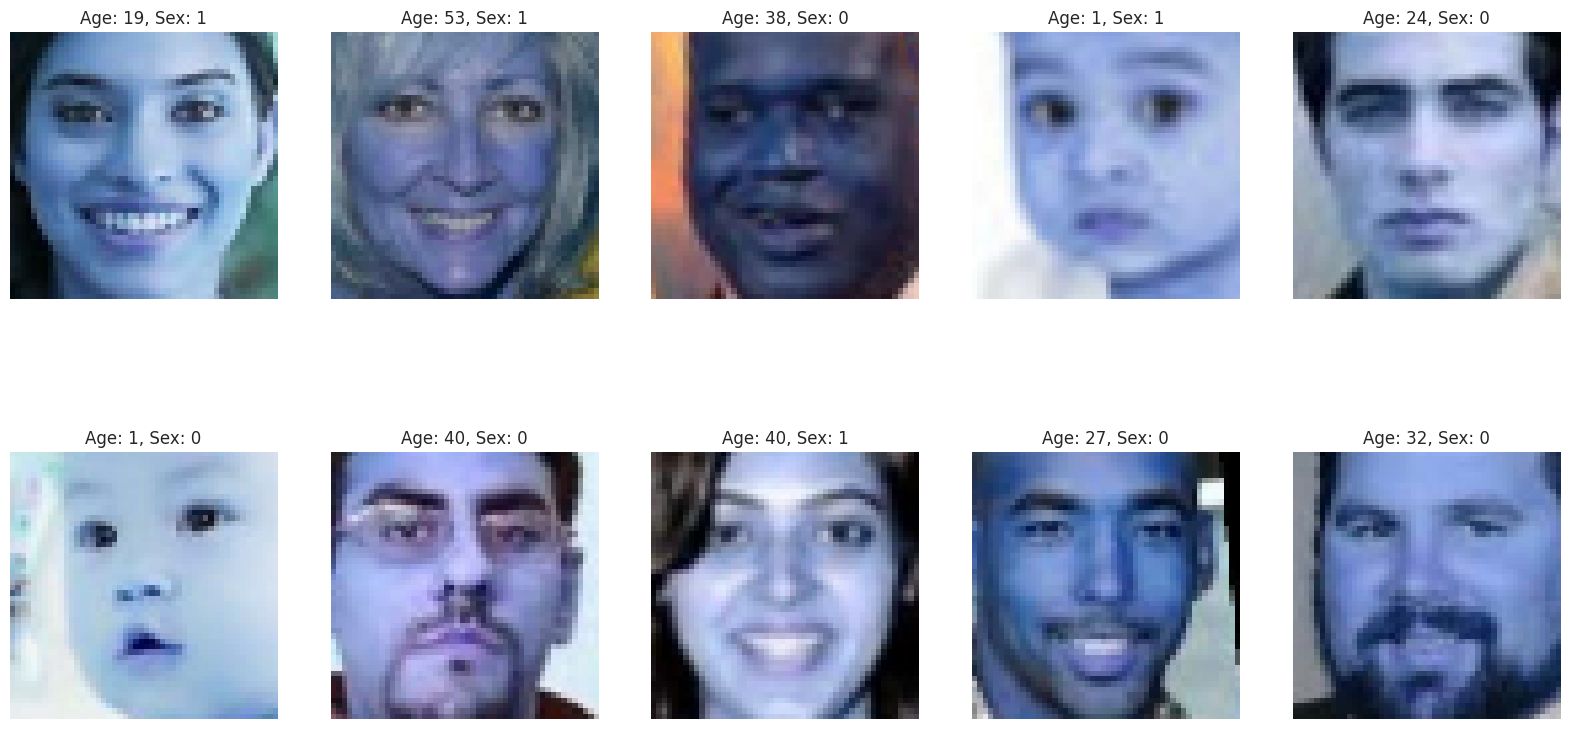

In [11]:
# Plot some pictures
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(2):
    for j in range(5):
        random_face = np.random.choice(len(df))

        age = df['age'][random_face]
        gender = df['gender'][random_face]

        axes[i][j].set_title('Age: {0}, Sex: {1}'.format(age, gender))
        axes[i][j].imshow(df['image'][random_face], cmap='gray')
        axes[i][j].axis('off')

# Age prediction¶


In [12]:
X = np.array(df['image'].to_list())

# The .reshape(50, 50, 3) method reshapes the 1D array into a 3D array with dimensions 50x50x3
# Since each image in the dataset is a flat array of length 50*50*3, where 3 represents the number of color channels (RGB)
X_reshaped = X.reshape(X.shape[0], 50, 50, 3)
X_reshaped.shape

(23708, 50, 50, 3)

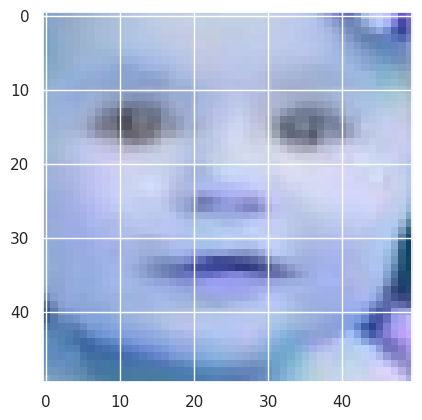

In [13]:
plt.imshow(X_reshaped[0])

In [14]:
# Normalize the pixel values in the 'X_reshaped' array by dividing each value by 255
# This scales the pixel values to the range [0, 1]
X_reshaped = X_reshaped / 255

In [15]:
# Extract the shape of the input data 'X_reshaped' excluding the first dimension (number of samples)
# This represents the shape of a single image in the dataset
input_shape = X_reshaped.shape[1:]
input_shape

(50, 50, 3)

In [46]:
y = df['age'].values

In [47]:
# Split the dataset into training and test/validation sets
# 40% of the data will be used for test/validation and the remaining 60% for training
# Again split into test and validation sets

X_train, X_testval, y_train, y_testval = train_test_split(X_reshaped, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.4, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((14224, 50, 50, 3),
 (14224,),
 (5690, 50, 50, 3),
 (5690,),
 (3794, 50, 50, 3),
 (3794,))

In [48]:
# Import Library
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,BatchNormalization,Dropout,Activation,Flatten
from keras.layers import Lambda, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras import regularizers

In [49]:
# Set up data augmentation parameters for training images
# Rotation, shifts, shearing, zooming, and horizontal flipping are applied for augmentation
datagen = ImageDataGenerator(rotation_range = 10,
                             width_shift_range = 0.05,
                             height_shift_range = 0.05,
                             shear_range = 0.05,
                             zoom_range = 0.1,
                             horizontal_flip = True)

# Data generators for validation and test data without augmentation
datagen_val = ImageDataGenerator()
datagen_test = ImageDataGenerator()


seed = 42

# Applies the data generators on training and validation data
# Train generator applies augmentation, validation generator does not
train_generator= datagen.flow(X_train, y_train,
                              batch_size = 128,
                              shuffle = True,
                              seed = seed)
val_generator= datagen_val.flow(X_val, y_val,
                                batch_size = 64,
                                shuffle = True,
                                seed = seed)

In [50]:
# Algorithms
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)
# Save the model with the minimum validation loss
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_loss', verbose = 1, mode = 'min',  save_best_only = True)
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.00001, mode = 'min', verbose = 1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d_3 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               655872    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 41s 165ms/step - loss: 275.7584 - val_loss: 976.8644 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 166.9976
Epoch 2: val_loss did not improve from 976.86444
112/112 [==============================] - 17s 149ms/step - loss: 166.9976 - val_loss: 1788.2275 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 149.0815
Epoch 3: val_loss did not improve from 976.86444
112/112 [==============================] - 18s 157ms/step - loss: 149.0815 - val_loss: 2144.8391 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - ETA: 0s - loss: 130.6831
Epoch 4: val_loss did not improve from 976.86444

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
112/112 [==============================] - 18s 157ms/step - loss: 130.6831 - val_loss: 993.7234 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - ETA: 0s - loss: 113.1621
Epoch 5: val_loss

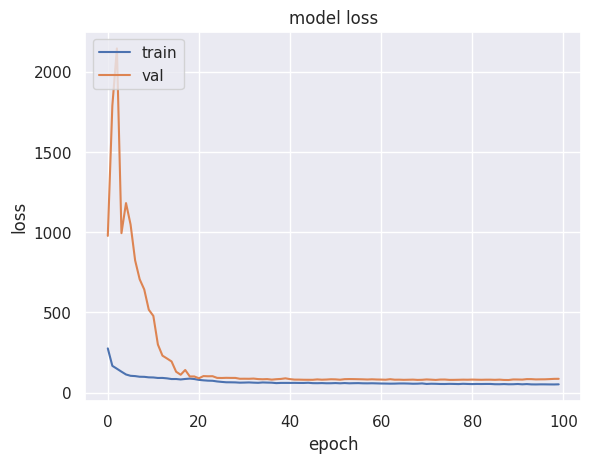

In [51]:
# Import Model
# MobileNetV2 - 14MB - 71.3% - 90.1% - 3.5M - 105
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
mbnv2 = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')
# Definition Model
def build_model(base_modelx):

    # Initialize a Sequential model with the base_modelx as the base
    model = Sequential(base_modelx)

    # Add a GlobalMaxPooling2D layer to reduce the spatial dimensions of the feature maps
    model.add(GlobalMaxPooling2D())

    # Flatten the output of the previous layer into a 1D array
    model.add(Flatten())

    # Add progresively dense layers with ReLU activation 
    # Progressively larger dropout for preventing overfitting
    model.add(Dense(512,activation ='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.1))

    model.add(Dense(256,activation ='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))

    model.add(Dense(128,activation ='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))

    # Final output layer with a single neuron (sice its a regression problem)
    model.add(Dense(1))
    print(model.summary())

    # Compile the model with Adam optimizer and mean squared error loss
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model(mbnv2)

#Model Trainning
history = model.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks = [checkpoint, reduce_lr])

# Ploting acc and loss
from matplotlib import pyplot as plt

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

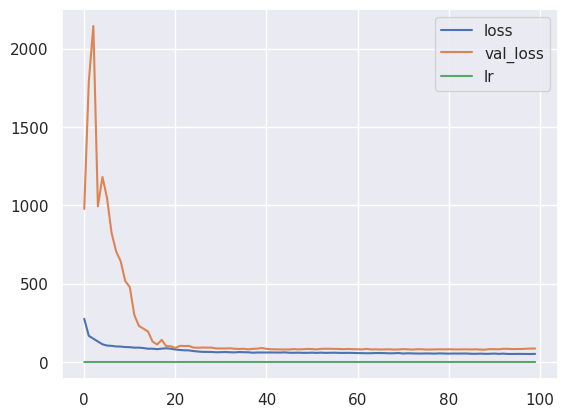

In [53]:
pd.DataFrame(history.history).plot();
plt.savefig('/content/drive/MyDrive/MSE_loss_age.png')

In [54]:
valid_score = model.evaluate(X_test, y_test, verbose=1)
valid_score

119/119 [==============================] - 1s 8ms/step - loss: 79.8460


79.84599304199219

In [55]:
y_pred = np.round(model.predict(X_test))
y_pred


119/119 [==============================] - 2s 7ms/step


array([[ 2.],
       [21.],
       [71.],
       ...,
       [28.],
       [59.],
       [33.]], dtype=float32)

In [56]:
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 6.214022140221402



# Gender prediction¶


In [37]:
#Do pretty much the same thing with gender values instead
y = df['gender'].values
# Train test split
X_train, X_testval, y_train, y_testval = train_test_split(X_reshaped, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.4, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((14224, 50, 50, 3),
 (14224,),
 (5690, 50, 50, 3),
 (5690,),
 (3794, 50, 50, 3),
 (3794,))

In [38]:
# Data Generator
datagen = ImageDataGenerator(rotation_range = 10,
                             width_shift_range = 0.05,
                             height_shift_range = 0.05,
                             shear_range = 0.05,
                             zoom_range = 0.1,
#                              brightness_range = [0.9,1.1],
                             horizontal_flip = True)
datagen_val = ImageDataGenerator()
datagen_test = ImageDataGenerator()

# Convert data gen
seed = 42
train_generator= datagen.flow(X_train, y_train,
                              batch_size = 128,
                              shuffle = True,
                              seed = seed)
val_generator= datagen_val.flow(X_val, y_val,
                                batch_size = 64,
                                shuffle = True,
                                seed = seed)

In [39]:
# Algorithms
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)
# Save the model with the minimum validation loss
checkpoint = ModelCheckpoint('best_model_gender.hdf5', monitor = 'val_loss', verbose = 1, mode = 'min',  save_best_only = True)
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.00001, mode = 'min', verbose = 1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d_2 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 41s 160ms/step - loss: 5.1201 - accuracy: 0.7743 - val_loss: 2.8353 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.8682
Epoch 2: val_loss did not improve from 2.83529
112/112 [==============================] - 17s 149ms/step - loss: 0.6583 - accuracy: 0.8682 - val_loss: 3.3727 - val_accuracy: 0.5086 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.8843
Epoch 3: val_loss improved from 2.83529 to 1.56109, saving model to best_model_gender.hdf5
112/112 [==============================] - 17s 154ms/step - loss: 0.3556 - accuracy: 0.8843 - val_loss: 1.5611 - val_accuracy: 0.6645 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8957
Epoch 4: val_loss improved from 1.56109 to 1.16615, saving model to best_model_gender.hdf5
112/112 [==============================

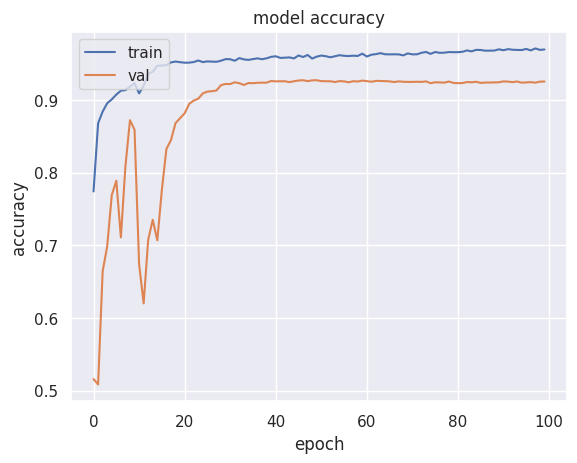

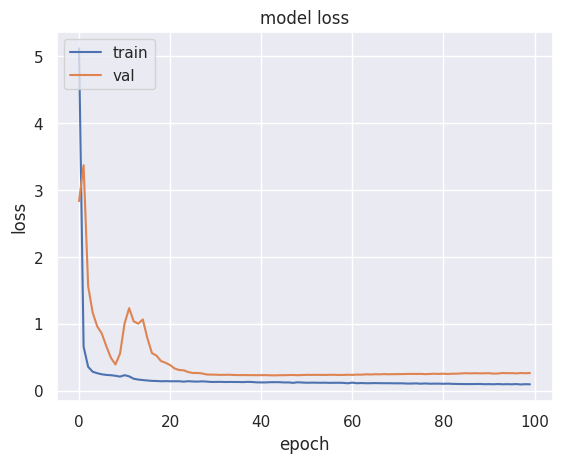

In [40]:
# Import Model
# MobileNetV2 - 14MB - 71.3% - 90.1% - 3.5M - 105
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
mbnv2 = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')
# Definition Model
def build_model(base_modelx):
    model = Sequential(base_modelx)
    model.add(GlobalMaxPooling2D())
    model.add(Flatten())

    model.add(Dense(512,activation ='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.1))

    model.add(Dense(256,activation ='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))

    model.add(Dense(128,activation ='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))

    #Since it's binary classification problem, we use sigmoid on last neuron
    model.add(Dense(1, activation = 'sigmoid',kernel_regularizer=regularizers.l2(0.01)))
    print(model.summary())

    #Since it's binary classification problem, we use log loss metric for loss
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model(mbnv2)

#Model Trainning
history = model.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks = [checkpoint, reduce_lr])

# Ploting acc and loss
from matplotlib import pyplot as plt
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

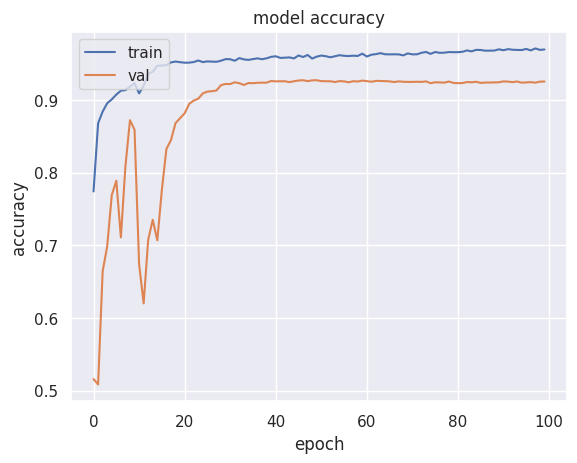

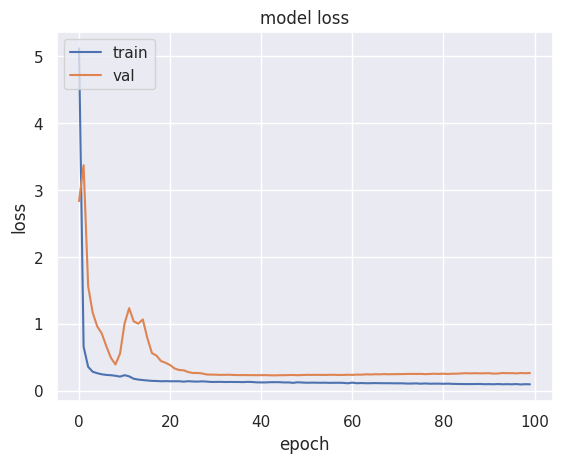

In [41]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/drive/MyDrive/Accuracy_gender.png')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/drive/MyDrive/Loss_gender.png')
plt.show()
model.save()

In [42]:
valid_score = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

119/119 [==============================] - 1s 10ms/step - loss: 0.2720 - accuracy: 0.9222
Accuracy for test set: 0.9222456216812134


In [43]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
y_pred

119/119 [==============================] - 2s 7ms/step


array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [44]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1986
           1       0.92      0.92      0.92      1808

    accuracy                           0.92      3794
   macro avg       0.92      0.92      0.92      3794
weighted avg       0.92      0.92      0.92      3794



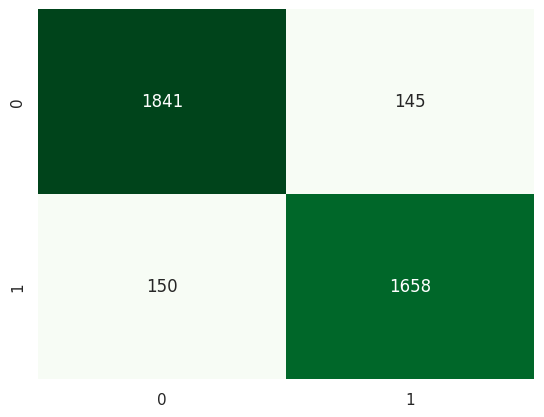

In [45]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');